# Zvi Badash 214553034
## Assignment 17
### Question 1 - Implementing an _Inverser Autoencoder_
The video explaining the exercise can be found [here](https://youtu.be/5s7z2aDHATs)

## Imports

In [ ]:
import torch
from tqdm.notebook import tqdm
from torch import nn
import torchvision as tv
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Defining the Inverser Autoencoder class

In [ ]:
class InverserAutoencoder(nn.Module):
    def __init__(self, encoder_layers, decoder_layers, loss_fn):
        super(InverserAutoencoder, self).__init__()
        self.encoder_layers = nn.ModuleList(encoder_layers)
        self.decoder_layers = nn.ModuleList(decoder_layers)
        self.encoder_layers_inputs = None
        self.decoder_layers_outputs = None
        self.loss_fn = loss_fn

    def encode(self, X):
        self.encoder_layers_inputs = []
        for layer in self.encoder_layers:
            self.encoder_layers_inputs.append(X)
            X = layer(X)
        return X

    def decode(self, X):
        self.decoder_layers_outputs = []
        for layer in self.decoder_layers:
            X = layer(X)
            self.decoder_layers_outputs.append(X)
        return X

    def _losses(self):
        for (enc_input, dec_output) in zip(self.encoder_layers_inputs,
                                           self.decoder_layers_outputs[::-1]):
            yield self.loss_fn(enc_input, dec_output)

    def last_loss(self):
        return sum(self._losses())

    def forward(self, X):
        return self.decode(self.encode(X))

    def children(self): # For the layer summary
        for layer in self.encoder_layers:
            yield layer

        for layer in self.decoder_layers:
            yield layer

## Defining a baseline, simple inverser autoencoder model

In [ ]:
encoder_layers = [
    nn.Sequential(nn.Linear(28*28, 256), nn.ReLU()),
    nn.Sequential(nn.Linear(256, 128), nn.ReLU()),
    nn.Sequential(nn.Linear(128, 64), nn.ReLU())
]

In [ ]:
decoder_layers = [
    nn.Sequential(nn.Linear(64, 128), nn.ReLU()),
    nn.Sequential(nn.Linear(128, 256), nn.ReLU()),
    nn.Sequential(nn.Linear(256, 28*28), nn.Sigmoid())
]

In [ ]:
baseline_model = InverserAutoencoder(encoder_layers, decoder_layers, nn.MSELoss())

## Loading the MNIST dataset

In [ ]:
batch_size = 256

In [ ]:
train_dataset = tv.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=tv.transforms.ToTensor())
test_dataset = tv.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=tv.transforms.ToTensor())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          shuffle=True)

## Training the model


In [ ]:
def train_loop(model, epochs, device=device, lr=0.01, flatten=True):
    model = model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    batch_losses = []
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as t_epoch:
            # Loss logging
            t_epoch.set_description(f"Epoch {epoch}")
            running_loss = torch.tensor([0.0]).to(device)

            for (X, _) in t_epoch:
                # Preprocess input tensor
                X = X.to(device)
                if flatten:
                    X = X.view(-1, 28*28)

                # Feed the image through the model and calculate loss
                optimizer.zero_grad()
                reconstructed_image = model(X)
                loss = model.last_loss()

                # Backwards pass
                loss.backward()
                optimizer.step()

                # Loss logging
                batch_losses.append(loss.item())
                running_loss += loss
                t_epoch.set_postfix(Loss=loss.item())
    return batch_losses

In [ ]:
loss_hist = train_loop(model=baseline_model, epochs=55, lr=0.0025)

Text(0.5, 1.0, 'Raw MSE Loss for baseline model')

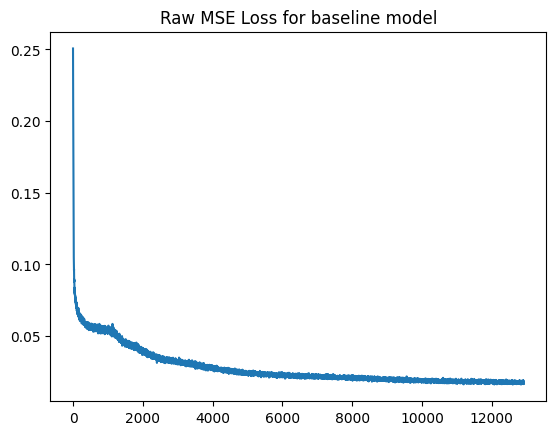

In [ ]:
plt.plot(loss_hist)
plt.title('Raw MSE Loss for baseline model')

## Generalizing building the layers

In [ ]:
def linear_encoder_layers_from_sizes(layer_output_sizes, hidden_dim):
    layer_output_sizes = [28*28] + layer_output_sizes + [hidden_dim]
    for i in range(len(layer_output_sizes) - 1):
            yield nn.Sequential(nn.Linear(layer_output_sizes[i], layer_output_sizes[i+1]), nn.ReLU())

In [ ]:
def linear_decoder_layers_from_sizes(layer_output_sizes, hidden_dim):
    layer_output_sizes = [hidden_dim] + layer_output_sizes[::-1] + [28*28]
    for i in range(len(layer_output_sizes) - 2):
            yield nn.Sequential(nn.Linear(layer_output_sizes[i], layer_output_sizes[i+1]), nn.ReLU())
    yield nn.Sequential(nn.Linear(layer_output_sizes[-2], layer_output_sizes[-1]), nn.Sigmoid())

## Experimenting with other models

In [ ]:
# Small hidden dim, less layers
sizes = [512], 10
small_model = InverserAutoencoder(
    linear_encoder_layers_from_sizes(*sizes),
    linear_decoder_layers_from_sizes(*sizes),
    nn.MSELoss()
)

In [ ]:
loss_hist = train_loop(model=small_model, epochs=30, lr=0.01)

Text(0.5, 1.0, 'Raw MSE Loss for small model')

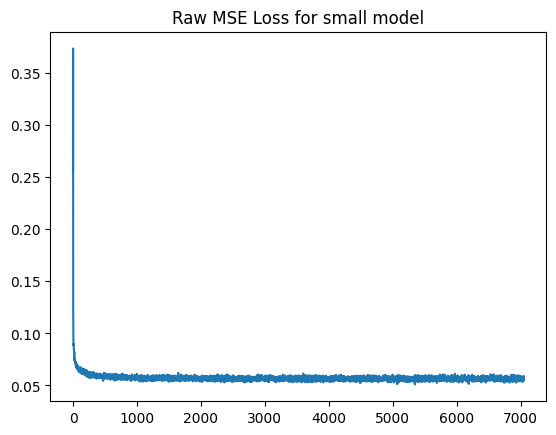

In [ ]:
plt.plot(loss_hist)
plt.title('Raw MSE Loss for small model')

In [ ]:
# Big hidden_dim, more layers
sizes = [512, 256, 256, 128, 128, 64], 128
big_model = InverserAutoencoder(
    linear_encoder_layers_from_sizes(*sizes),
    linear_decoder_layers_from_sizes(*sizes),
    nn.MSELoss()
)

In [ ]:
loss_hist = train_loop(model=big_model, epochs=30, lr=0.001)

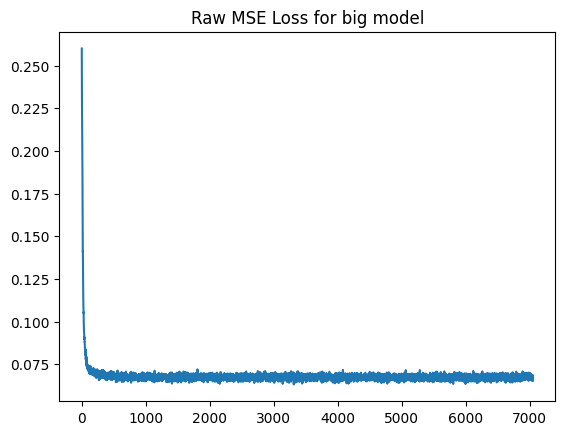

In [ ]:
plt.plot(loss_hist)
plt.title('Raw MSE Loss for big model')
plt.show()

## Trying convolutional models

In [ ]:
def layer_summary(model, X_shape):
    X = torch.randn(*X_shape)
    for layer in model.children():
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
encoder_layers = [
    nn.Sequential(nn.Conv2d(1, 16,  kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2), nn.ReLU())
]

In [ ]:
decoder_layers = [
    nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1, padding=2), nn.Sigmoid())
]

In [ ]:
conv_model = InverserAutoencoder(encoder_layers, decoder_layers, nn.MSELoss())

In [ ]:
layer_summary(conv_model, (batch_size, 1, 28, 28))

Sequential output shape:	 torch.Size([256, 16, 15, 15])
Sequential output shape:	 torch.Size([256, 32, 9, 9])
Sequential output shape:	 torch.Size([256, 64, 6, 6])
Sequential output shape:	 torch.Size([256, 32, 9, 9])
Sequential output shape:	 torch.Size([256, 16, 15, 15])
Sequential output shape:	 torch.Size([256, 1, 28, 28])


In [ ]:
loss_hist = train_loop(model=conv_model, epochs=7, lr=0.003, flatten=False)

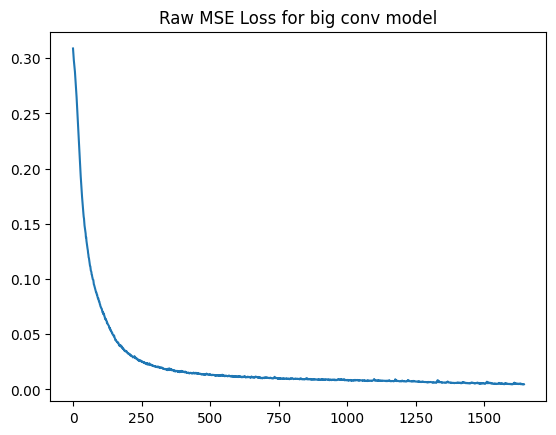

In [ ]:
plt.plot(loss_hist)
plt.title('Raw MSE Loss for big conv model')
plt.show()

In [ ]:
encoder_layers = [
    nn.Sequential(nn.Conv2d(1, 16 , kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.Conv2d(32, 8, kernel_size=3, stride=2, padding=2), nn.ReLU())
]

In [ ]:
decoder_layers = [
    nn.Sequential(nn.ConvTranspose2d(8, 32, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=2), nn.ReLU()),
    nn.Sequential(nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1, padding=2), nn.Sigmoid())
]

In [ ]:
small_conv_model = InverserAutoencoder(encoder_layers, decoder_layers, nn.MSELoss())

In [ ]:
layer_summary(small_conv_model, (batch_size, 1, 28, 28))

Sequential output shape:	 torch.Size([256, 16, 15, 15])
Sequential output shape:	 torch.Size([256, 32, 9, 9])
Sequential output shape:	 torch.Size([256, 8, 6, 6])
Sequential output shape:	 torch.Size([256, 32, 9, 9])
Sequential output shape:	 torch.Size([256, 16, 15, 15])
Sequential output shape:	 torch.Size([256, 1, 28, 28])


In [ ]:
loss_hist = train_loop(model=small_conv_model, epochs=7, lr=0.001, flatten=False)

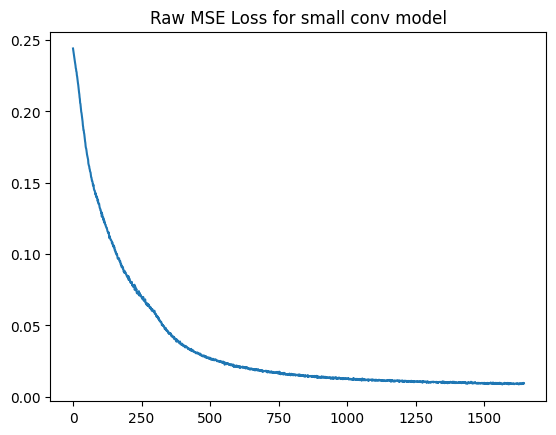

In [ ]:
plt.plot(loss_hist)
plt.title('Raw MSE Loss for small conv model')
plt.show()

## Testing the models on a few sample images

In [ ]:
image_idxs = [0, 75, 24, 394, 13, 67, 21, 89]
models = [model.to('cpu') for model in [baseline_model, small_model, big_model,
                                        conv_model,small_conv_model]]
labels = ['Baseline model', 'Small model', 'Big model',
          'Conv. model', 'Small conv. model']
flatten = [True] * 3 + [False] * 2

In [ ]:
for model in models:
    model.eval()

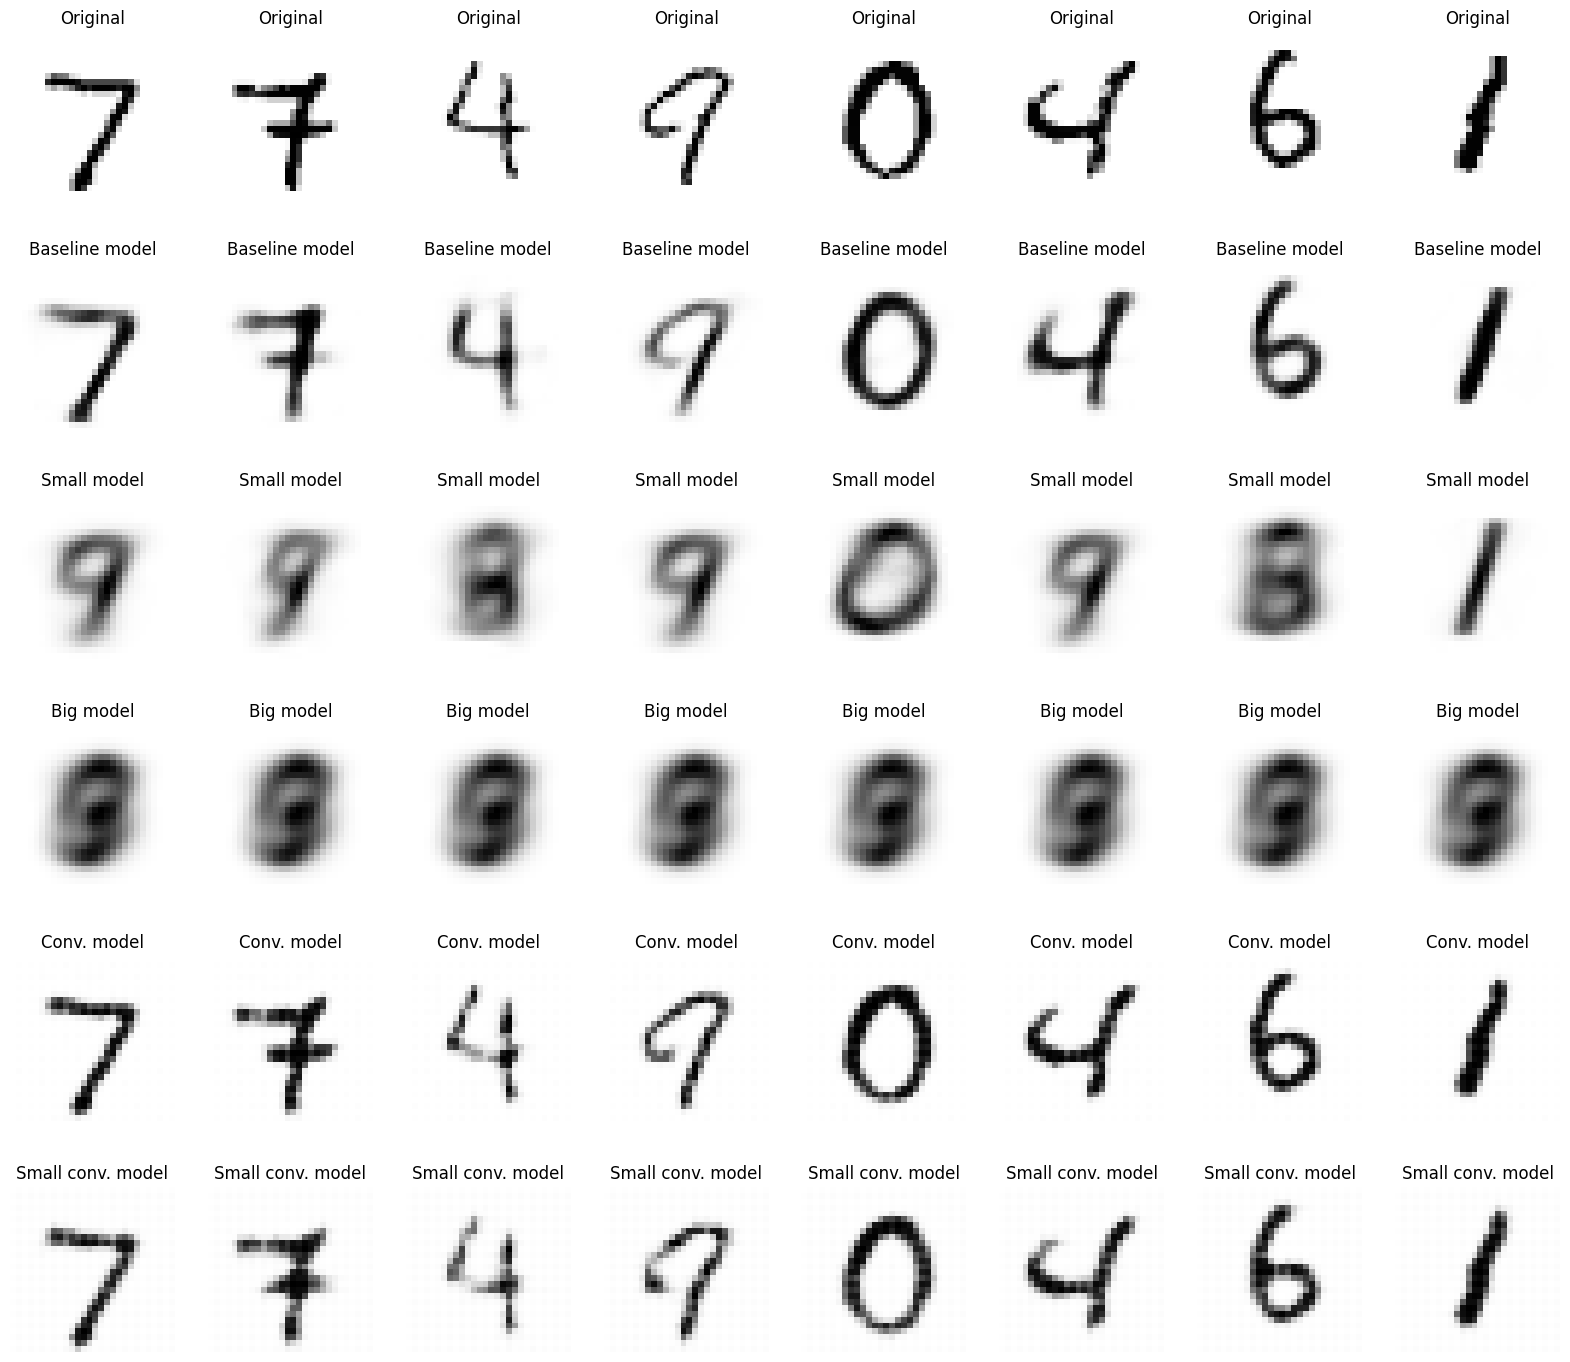

In [ ]:
fig, axes = plt.subplots(nrows=len(models) + 1, ncols=len(image_idxs), figsize=(20, 17.5))
for i, image_idx in enumerate(image_idxs):
    axes[0, i].imshow(test_dataset[image_idx][0].squeeze(), cmap='Greys')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    for j, model in enumerate(models):
        image = test_dataset[image_idx][0]
        if flatten[j]:
            image = image.view(1, 28*28)
        else:
            image = image.view(1, 1, 28, 28)


        axes[j+1, i].imshow(model(image).view(28, 28).cpu().detach().numpy(), cmap='Greys')
        axes[j+1, i].set_title(labels[j])
        axes[j+1, i].axis('off')

## Results

Let's look at the performance of each of the conv. models and of the fully connected models

In [ ]:
n_samples = 1000
models = [baseline_model, big_model, small_model, conv_model, small_conv_model]
labels = ['Baseline model', 'Big model', 'Small model', 'Conv. model', 'Small conv. model']
flatten = [True] * 3 + [False] * 2

In [ ]:
for model in models:
    model.eval()

In [ ]:
for i, model in enumerate(models):
    loss = 0
    for _, (image, _) in list(enumerate(test_dataset))[:n_samples]:
        if flatten[i]:
            image = image.view(1, 28*28)
        else:
            image = image.view(1, 1, 28, 28)
        reconstruction = model(image)
        loss += model.last_loss().item()
    print(f'{labels[i]} MSE loss on test set: {loss / n_samples:.5f}')

Baseline model MSE loss on test set: 0.01788
Big model MSE loss on test set: 0.06484
Small model MSE loss on test set: 0.05478
Conv. model MSE loss on test set: 0.00485
Small conv. model MSE loss on test set: 0.00910


### And each layer separately

In [ ]:
layer_losses = [torch.zeros((n_samples, len(model._losses()))) for model in models]

In [ ]:
for i in range(n_samples):
    image = test_dataset[i][0]
    for j, model in list(enumerate(models))[:n_samples]:
        if flatten[j]:
            image = image.view(1, 28*28)
        else:
            image = image.view(1, 1, 28, 28)
        reconstruction = model(image)
        layer_losses[j][i] = torch.tensor(model._losses())

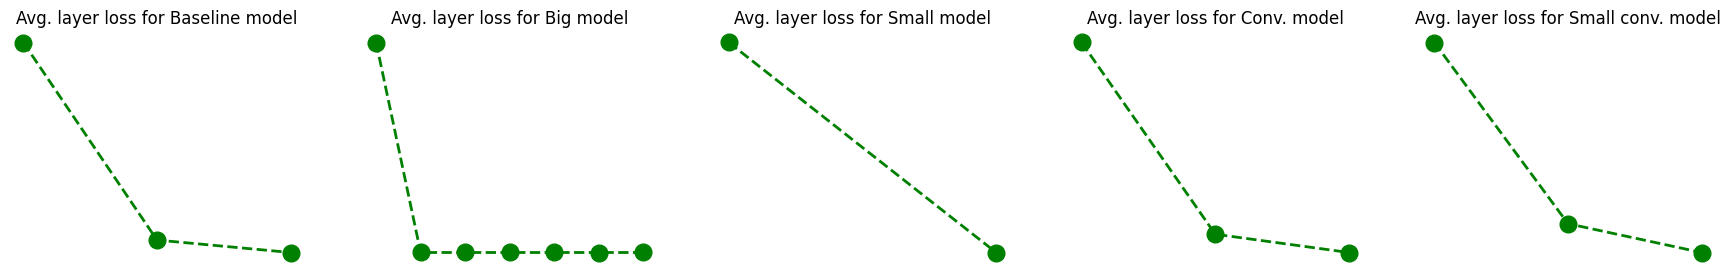

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(layer_losses), figsize=(22, 3))
for i, image_idx in enumerate(layer_losses):
    axes[i].plot(layer_losses[i].mean(dim=0).numpy(), 'go--', linewidth=2, markersize=12)
    axes[i].set_title(f'Avg. layer loss for {labels[i]}')
    axes[i].axis('off')

### Compression rates

In [ ]:
hidden_dims = [
    128,
    128,
    10,
    2304, # hidden_dim = min(output_channels x H x w)
    288
]

In [ ]:
rates = [
    (28*28 / hd) for hd in hidden_dims
]

In [ ]:
for (label, rate) in zip(labels, rates):
    print(f'{label} has compressed the data by {100 * rate:.2f}%')

Baseline model has compressed the data by 612.50%
Big model has compressed the data by 612.50%
Small model has compressed the data by 7840.00%
Conv. model has compressed the data by 34.03%
Small conv. model has compressed the data by 272.22%


## Comparing the models

Obviously, the convolutional models gave the best results, and that might be from MNIST's inherent easy-to-learn patterns like `vertical line`, `small loop`, `big loop` etc. because of this inherent ability of the data to be represented by a convolutional model that learns local patterns and not global relationships between singular pixels, we probably get a way "better" latent space of the data.

Also, We see that the output of the fully connected models is slightly less "crisp", the pixels that surrounds the digit have lower values in the convolutional models. This, again, is probably due to the nature of the models and the fact that the fully connected models learns a representation of the data that is pixel-wise and thus it's slightly more inclined to be uncertain about the values that surrounds the digits themselves (opposed to the conv. model that learns a "pattern-wise" representation of the data and is more certain about nearing pixels).